1. Retrieval

In [14]:
file_path="data/UU_Nomor_40_Tahun_2004.pdf"

In [15]:
# Import Library
from langchain_community.document_loaders import PyPDFLoader
import textwrap

loader = PyPDFLoader(file_path, mode="single")

pdf_data = loader.load()

print(len(pdf_data[0].page_content))

54549


In [16]:
# Only to check data had retrieved
pages = []
async for page in loader.alazy_load():
    pages.append(page)

print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'Acrobat Distiller 7.0 (Windows)', 'creator': 'Acrobat PDFMaker 7.0 for Word', 'creationdate': '2008-09-24T08:19:06+07:00', 'author': '', 'moddate': '2008-09-24T08:19:35+07:00', 'sourcemodified': 'D:20080924011851', 'title': 'uu no 40 th 2004', 'source': 'data/UU_Nomor_40_Tahun_2004.pdf', 'total_pages': 45}

PRESIDEN 
REPUBLIK INDONESIA 
 
UNDANG-UNDANG REPUBLIK INDONESIA 
NOMOR   40   TAHUN 2004 
TENTANG 
SISTEM JAMINAN SOSIAL NASIONAL 
 
DENGAN RAHMAT TUHAN YANG MAHA ESA 
 
PRESIDEN REPUBLIK INDONESIA, 
Menimbang : a.   bahwa setiap orang berhak atas jaminan sosial untuk dapat memenuhi 
kebutuhan dasar hidup yang layak dan meningkatkan martabatnya menuju 
terwujudnya masyarakat Indonesia yang sejahtera, adil, dan makmur; 
b. bahwa untuk memberikan jaminan sosial yang menyeluruh, negara 
mengembangkan Sistem Jaminan Sosial  Nasional bagi seluruh rakyat 
Indonesia; 
c. bahwa berdasarkan pertimbangan se bagaimana dimaksud dalam huruf a 
dan huruf b, perlu membentuk Unda ng-

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n","."],
    chunk_size=1000,
    chunk_overlap=100,
)

pdf_doc_chunks=text_splitter.split_documents(pdf_data)

2. Data Splitting or Chunking

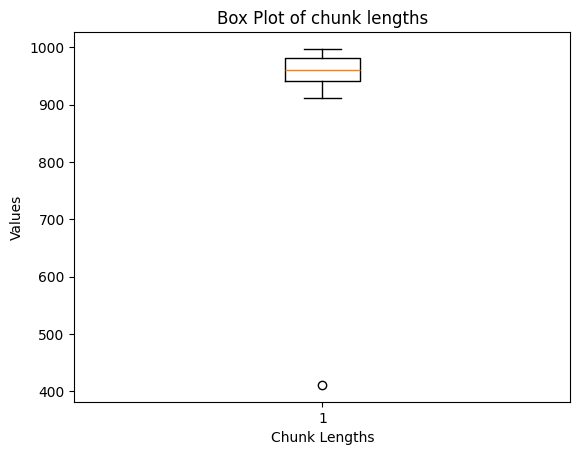

The median chunk lenght is : 960.0
The average chunk lenght is : 952.16
The minimum chunk lenght is : 411
The max chunk lenght is : 997
The 75th percentile chunk length is : 981.0
The 25th percentile chunk length is : 940.75


In [18]:
import matplotlib.pyplot as plt
import numpy as np

data = [len(doc.page_content) for doc in pdf_doc_chunks]

plt.boxplot(data)  
plt.title('Box Plot of chunk lengths')  # Title 
plt.xlabel('Chunk Lengths')  # Label for x-axis
plt.ylabel('Values')  # Label for y-axis

plt.show()

print(f"The median chunk lenght is : {round(np.median(data),2)}")
print(f"The average chunk lenght is : {round(np.mean(data),2)}")
print(f"The minimum chunk lenght is : {round(np.min(data),2)}")
print(f"The max chunk lenght is : {round(np.max(data),2)}")
print(f"The 75th percentile chunk length is : {round(np.percentile(data, 75),2)}")
print(f"The 25th percentile chunk length is : {round(np.percentile(data, 25),2)}")

3. Data Transformation or Embeddings

In [19]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
hf_embeddings = embeddings.embed_documents([chunk.page_content for chunk in pdf_doc_chunks])

print(f"The lenght of the embeddings vector is {len(hf_embeddings[0])}")
print(f"The embeddings object is an array of {len(hf_embeddings)} X {len(hf_embeddings[0])}")

The lenght of the embeddings vector is 768
The embeddings object is an array of 62 X 768


In [20]:
from dotenv import load_dotenv
import os

if load_dotenv():
    print("Success: .env file found with some environment variables")
else:
    print("Caution: No environment variables found. Please create .env file in the root directory or add environment variables in the .env file")

api_key=os.environ["OPENAI_API_KEY"]

from openai import OpenAI

client = OpenAI()

if api_key:
    try:
        client.models.list()
        print("OPENAI_API_KEY is set and is valid")
    except openai.APIError as e:
        print(f"OpenAI API returned an API Error: {e}")
        pass
    except openai.APIConnectionError as e:
        print(f"Failed to connect to OpenAI API: {e}")
        pass
    except openai.RateLimitError as e:
        print(f"OpenAI API request exceeded rate limit: {e}")
        pass

else:
    print("Please set you OpenAI API key as an environment variable OPENAI_API_KEY")

Success: .env file found with some environment variables
OPENAI_API_KEY is set and is valid


In [21]:
from langchain_openai import OpenAIEmbeddings

os.environ["TOKENIZERS_PARALLELISM"]="false"

pdf_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
pdf_doc_embeddings=embeddings.embed_documents([chunk.page_content for chunk in pdf_doc_chunks])

print(f"The lenght of the embeddings vector is {len(pdf_doc_embeddings[0])}")
print(f"The embeddings object is an array of {len(pdf_doc_embeddings)} X {len(pdf_doc_embeddings[0])}")

The lenght of the embeddings vector is 768
The embeddings object is an array of 62 X 768


4. Vector Storage

In [22]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

storage_file_path="./memory"
storage_index_name="PDF_index"

index = faiss.IndexFlatIP(len(pdf_doc_embeddings[0]))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

vector_store.add_documents(documents=pdf_doc_chunks)
vector_store.save_local(folder_path=storage_file_path,index_name=storage_index_name)

Generation Pipeline

1. Retrieval

In [23]:
# Load the FAISS vector store with safe deserialization
vector_store = FAISS.load_local(folder_path=storage_file_path, index_name=storage_index_name, embeddings=embeddings, allow_dangerous_deserialization=True)

# Define a query
query = "Sebutkan prinsip-prinsip penyelenggaraan Sistem Jaminan Sosial Nasional yang termaktub dalam UU ini!"

# Perform similarity search
retrieved_docs = vector_store.similarity_search(query, k=2)  # Get top 2 relevant chunks

# Display results
for i, doc in enumerate(retrieved_docs):
    print(textwrap.fill(f"\nRetrieved Chunk {i+1}:\n{doc.page_content}",width=100))
    print("\n\n")

 Retrieved Chunk 1: menanggung beban biaya jaminan sosial, yang diwujudkan dengan kewajiban setiap
peserta  membayar iuran sesuai dengan tingkat gaji, upah, atau penghasilannya.    Prinsip nirlaba
dalam ketentuan ini adalah prinsip pengelolaan usaha yang  mengutamakan penggunaan hasil pengem
bangan dana untuk me mberikan manfaat  sebesar-besarnya bagi seluruh peserta.   Prinsip keterbukaan
dalam ketentuan ini ad alah prinsip mempermudah akses informasi  yang lengkap, benar, dan jelas bagi
setiap peserta.   Prinsip kehati-hatian dalam ketentuan ini adal ah prinsip pengelolaan dana secara
cermat,  teliti, aman, dan tertib.    Prinsip akuntabilitas dalam ketentuan in i adalah prinsip
pelaksanaan program dan  pengelolaan keuangan yang akurat dan dapat dipertanggungjawabkan.
Prinsip portabilitas dalam ketentuan ini adalah prinsip memberikan jaminan yang  berkelanjutan
meskipun peserta berpindah pek erjaan atau tempat tinggal dalam wilayah  Negara Kesatuan Republik
Indonesia.



 Retrieved C

2. Augmentation

In [24]:
retrieved_context=retrieved_docs[0].page_content + retrieved_docs[1].page_content

# Creating the prompt
augmented_prompt=f"""

Given the context below answer the question.

Question: {query} 

Context : {retrieved_context}

Remember to answer only based on the context provided and not from any other source. 

If the question cannot be answered based on the provided context, say I don’t know.

"""

print(textwrap.fill(augmented_prompt,width=150))

  Given the context below answer the question.  Question: Sebutkan prinsip-prinsip penyelenggaraan Sistem Jaminan Sosial Nasional yang termaktub dalam
UU ini!   Context : menanggung beban biaya jaminan sosial, yang diwujudkan dengan kewajiban setiap peserta  membayar iuran sesuai dengan tingkat gaji,
upah, atau penghasilannya.    Prinsip nirlaba dalam ketentuan ini adalah prinsip pengelolaan usaha yang  mengutamakan penggunaan hasil pengem bangan
dana untuk me mberikan manfaat  sebesar-besarnya bagi seluruh peserta.   Prinsip keterbukaan dalam ketentuan ini ad alah prinsip mempermudah akses
informasi  yang lengkap, benar, dan jelas bagi setiap peserta.   Prinsip kehati-hatian dalam ketentuan ini adal ah prinsip pengelolaan dana secara
cermat,  teliti, aman, dan tertib.    Prinsip akuntabilitas dalam ketentuan in i adalah prinsip pelaksanaan program dan  pengelolaan keuangan yang
akurat dan dapat dipertanggungjawabkan.     Prinsip portabilitas dalam ketentuan ini adalah prinsip memberik

3. Generation

In [25]:
from langchain_openai import ChatOpenAI


# Set up LLM and embeddings
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
)

messages=[("human",augmented_prompt)]

ai_msg = llm.invoke(messages)
ai_msg.content
print(ai_msg.content)

Prinsip-prinsip penyelenggaraan Sistem Jaminan Sosial Nasional yang termaktub dalam UU ini adalah sebagai berikut:

1. **Prinsip Nirlaba**: Pengelolaan usaha yang mengutamakan penggunaan hasil pengembangan dana untuk memberikan manfaat sebesar-besarnya bagi seluruh peserta.
2. **Prinsip Keterbukaan**: Mempermudah akses informasi yang lengkap, benar, dan jelas bagi setiap peserta.
3. **Prinsip Kehati-hatian**: Pengelolaan dana secara cermat, teliti, aman, dan tertib.
4. **Prinsip Akuntabilitas**: Pelaksanaan program dan pengelolaan keuangan yang akurat dan dapat dipertanggungjawabkan.
5. **Prinsip Portabilitas**: Memberikan jaminan yang berkelanjutan meskipun peserta berpindah pekerjaan atau tempat tinggal dalam wilayah Negara Kesatuan Republik Indonesia.
6. **Prinsip Kepesertaan Bersifat Wajib**: Seluruh rakyat menjadi peserta untuk terlindungi, dengan penerapan yang disesuaikan dengan kemampuan ekonomi rakyat dan Pemerintah.
7. **Prinsip Dana Amanat**: Dana yang terkumpul dari iuran p